# Introduction

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import sqrtm
np.set_printoptions(suppress=True)      # to avoid scientific notation

### Data preparation

In [2]:
# cac40.csv contains adjusted close prices from 2023 April to 2025 June 
cac40 = pd.read_csv('cac40.csv',index_col="Date")
cac40_evolution = cac40['^FCHI']/cac40['^FCHI'].iloc[0]

returns = cac40.drop(columns=['^FCHI']).pct_change().dropna()
tickers = returns.columns
T,N = returns.shape

# Optimisation Problem

## Weights initialisation

10
1.482446385903078


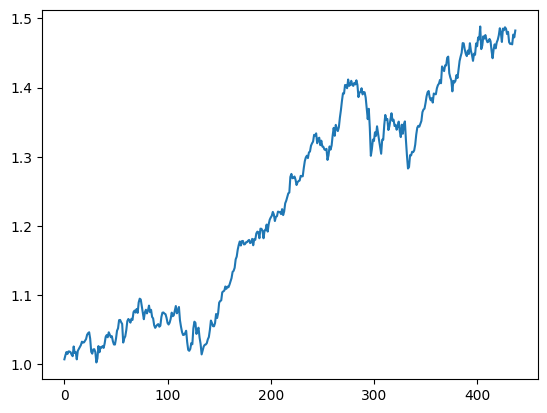

In [ ]:
# Initialisation window: Jan 22 - Dec 24
returns_init = returns.loc[:'2025-01-01'].to_numpy()
w = cvx.Variable(N)
portfolio_value = cvx.cumprod(1 + returns_init@w )

# Expected log-growth
g = cvx.mean( cvx.log( 1 + returns_init@w ) , axis=0)

# Volatility as variance 
variance = cvx.var(returns_init@w)

# Problem formulation
objective = cvx.Maximize(g)
constraints = [w>=0, cvx.sum(w)==1,variance<=5e-5]
kelly_opt = cvx.Problem(objective=objective,constraints=constraints)
kelly_opt.solve()
w_0 = np.round(w.value,4)

print(np.sum(w.value>0.01))
print(portfolio_value.value[-1])
plt.plot(portfolio_value.value)
plt.show()

## Dynamic re-allocation

# Results analysis

## Influence of the time window

## Influence of the turnover constraint